In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F, BCELoss

ValTransform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((14, 14)),
    transforms.Lambda(lambda x: torch.where(x > 0.5, torch.tensor(1.0), torch.tensor(0.0))),
])

traindata = datasets.MNIST(root='./data', train=True, download=True)
valdata = datasets.MNIST(root='./data', train=False, download=True, transform=ValTransform)

# Use list comprehensions and PyTorch operations to replace the two for loops
balanced_train_data = [torch.where(transforms.ToTensor()(img.resize((14, 14))) > 0.5, torch.tensor(1.0), torch.tensor(0.0))
                       for i in range(10) for img, label in traindata if label == i][:10000]

balanced_train_labels = [i for i in range(10) for _ in range(1000)]

# Convert the lists to PyTorch tensors
balanced_train_data = torch.stack(balanced_train_data)
balanced_train_labels = torch.tensor(balanced_train_labels)


In [2]:
dataloader = DataLoader(list(zip(balanced_train_data, balanced_train_labels)), batch_size=32, shuffle=True)

In [3]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(196, 128)
        self.fc2 = nn.Linear(128, 16)  # Outputs for both mean and logvar
        # Decoder
        self.fc3 = nn.Linear(8, 128)
        self.fc4 = nn.Linear(128, 196)

    def encode(self, x):
        h1 = torch.tanh(self.fc1(x))
        return self.fc2(h1).chunk(2, dim=1)  # Split the output into mu and logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.tanh(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 196))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [4]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 196), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE, KLD

In [5]:
autoencoder = Autoencoder()
optimizer = torch.optim.Adam(autoencoder.parameters())
train_losses = []
BCE_losses = []
KLD_losses = []

for epoch in range(1, 51):
    autoencoder.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = autoencoder(data)
        BCE, KLD = loss_function(recon_batch, data, mu, logvar)
        loss = BCE + KLD
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        BCE_losses.append(BCE.item())
        KLD_losses.append(KLD.item())
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(dataloader.dataset)))
    train_losses.append(train_loss / len(dataloader.dataset))

====> Epoch: 1 Average loss: 51.4450
====> Epoch: 2 Average loss: 35.1199
====> Epoch: 3 Average loss: 32.2175
====> Epoch: 4 Average loss: 30.5752
====> Epoch: 5 Average loss: 29.2896
====> Epoch: 6 Average loss: 28.4133
====> Epoch: 7 Average loss: 27.9420
====> Epoch: 8 Average loss: 27.5322
====> Epoch: 9 Average loss: 27.1733
====> Epoch: 10 Average loss: 26.8306
====> Epoch: 11 Average loss: 26.5535
====> Epoch: 12 Average loss: 26.2796
====> Epoch: 13 Average loss: 26.0514
====> Epoch: 14 Average loss: 25.8686
====> Epoch: 15 Average loss: 25.6743
====> Epoch: 16 Average loss: 25.4970
====> Epoch: 17 Average loss: 25.3109
====> Epoch: 18 Average loss: 25.1729
====> Epoch: 19 Average loss: 25.0492
====> Epoch: 20 Average loss: 24.8577
====> Epoch: 21 Average loss: 24.7843
====> Epoch: 22 Average loss: 24.6988
====> Epoch: 23 Average loss: 24.6149
====> Epoch: 24 Average loss: 24.4867
====> Epoch: 25 Average loss: 24.4079
====> Epoch: 26 Average loss: 24.3366
====> Epoch: 27 Avera

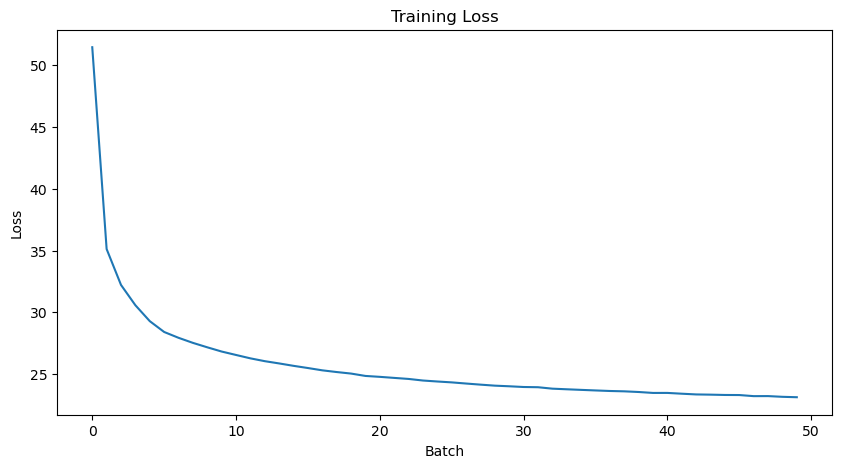

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

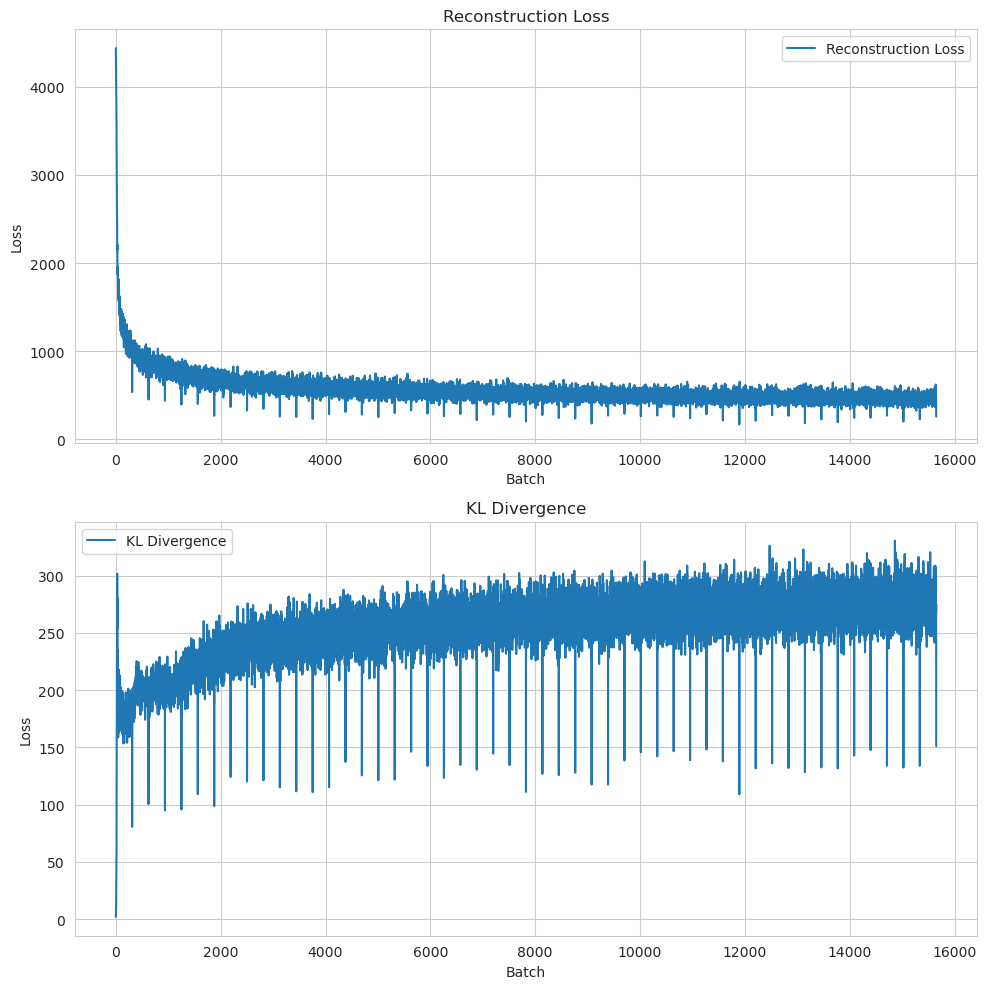

In [13]:
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.set_style("whitegrid")

plt.subplot(2, 1, 1)
plt.plot(BCE_losses, label='Reconstruction Loss')
plt.title("Reconstruction Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(KLD_losses, label='KL Divergence')
plt.title("KL Divergence")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

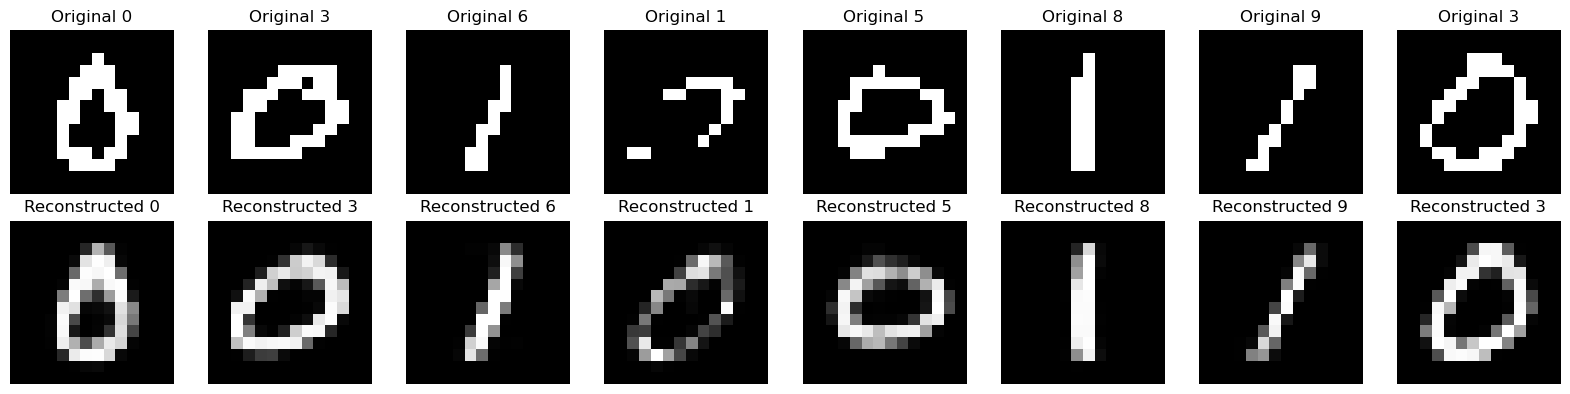

In [8]:
images, labels = next(iter(dataloader))
images = images[:8]
labels = labels[:8]

# Run the images through the autoencoder
recon_images, _, _ = autoencoder(images)

# Convert the images to numpy arrays
images = images.detach().numpy()
recon_images = recon_images.detach().numpy()

# Plot the original and reconstructed images side by side
fig, axs = plt.subplots(2, 8, figsize=(16, 4))

for i in range(8):
    # Original images
    axs[0, i].imshow(images[i].reshape(14, 14), cmap='gray')
    axs[0, i].set_title(f'Original {labels[i]}')
    axs[0, i].axis('off')
    # Reconstructed images
    axs[1, i].imshow(recon_images[i].reshape(14, 14), cmap='gray')
    axs[1, i].set_title(f'Reconstructed {labels[i]}')
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()

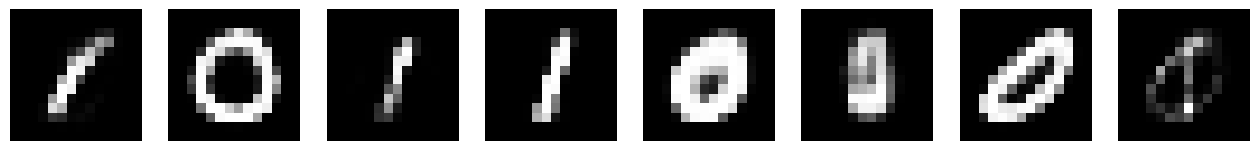

In [9]:
# Sample z from a standard Gaussian distribution
z = torch.randn(8, 8)

# Run the decoder network to synthesize an image
syn_images = autoencoder.decode(z)

# Convert the synthesized images to numpy arrays
syn_images = syn_images.detach().numpy()

# Plot the synthesized images
fig, axs = plt.subplots(1, 8, figsize=(16, 2))

for i in range(8):
    axs[i].imshow(syn_images[i].reshape(14, 14), cmap='gray')
    axs[i].axis('off')

plt.show()

In [11]:
val_dataloader = DataLoader(valdata, batch_size=100, shuffle=True)

def validate(autoencoder, dataloader):
    autoencoder.eval()
    val_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(dataloader):
            recon_batch, mu, logvar = autoencoder(data)
            BCE, KLD = loss_function(recon_batch, data, mu, logvar)
            val_loss += BCE.item() + KLD.item()
    return val_loss / len(dataloader.dataset)

all_train_losses = []
all_val_losses = []
update_count = 0

for epoch in range(1, 51):
    for batch_idx, (data, _) in enumerate(dataloader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = autoencoder(data)
        BCE, KLD = loss_function(recon_batch, data, mu, logvar)
        loss = BCE + KLD
        loss.backward()
        optimizer.step()
        
        all_train_losses.append(BCE.item()/len(dataloader))
        
        update_count += 1
        if update_count % 100 == 0:
            val_loss = validate(autoencoder, val_dataloader)
            all_val_losses.append(val_loss/len(val_dataloader))

/home/anirudhkailaje/.local/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


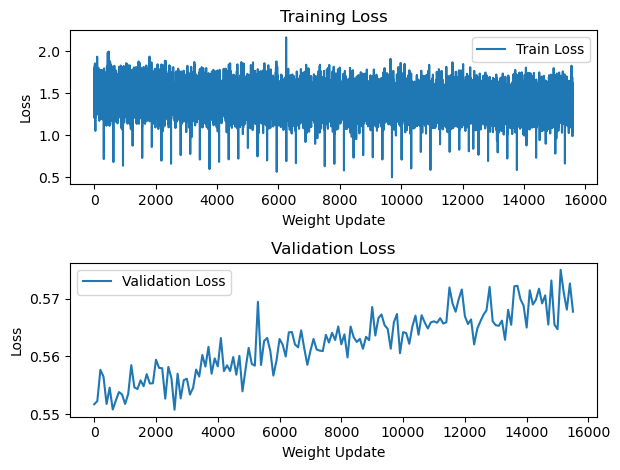

In [12]:
plt.subplot(2, 1, 1)
plt.plot(all_train_losses[:-50], label='Train Loss')  # Exclude the last value
plt.title("Training Loss")
plt.xlabel("Weight Update")
plt.ylabel("Loss")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(range(0, len(all_train_losses[:-50]), 100), all_val_losses, label='Validation Loss')
plt.title("Validation Loss")
plt.xlabel("Weight Update")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()